In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
from mmcls.models.builder import build_classifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import cm
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from mmseg.datasets.builder import build_dataset, build_dataloader, DATASETS
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import pandas
import json
import seaborn as sns

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs
from scripts import visualize_cam_results
from scripts.utils.BlurDataset import get_blurred_dataset
from scripts.utils import preprocessing, io
from scripts.utils.model import get_wrongly_classified
from scripts.utils.evaluation import compare_original_blurred, get_eval_metrics
from scripts import evaluate_effectiveness
from scripts.generate_blurred import generate_blurred

Importing BlurSegments step into Pipeline


In [2]:
configSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/ocrnet_hr48_512x512_carparts_noflip.py'
checkpointSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth'

segDataPathOriginal = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz'
segDataPathColor = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Color/valAllSegs.npz'
segDataPathWeb = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Web/valAllSegs.npz'
segDataPathStanford = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/StanfordCars_Original/valAllSegs.npz'

paletteName='Comp_Original_Ocrnet_Carparts_Noflip'

segDataPathOG = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz'
segDataPathNoScaleOG = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegsNoScale.npz'
segDataPathNoScaleWeb = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Web/valAllSegsNoScale.npz'
segDataPathNoScaleStanford = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/StanfordCars_Original/valAllSegsNoScale.npz'

camDataGradCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMs.npz'
camDataEigenCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigen.npz'
camDataEigenGrad = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigenGrad.npz'
camDataGradCAMGPU = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGPU.npz'
camDataGradCAMPlusPlus = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGrad++.npz'
camDataLayerCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsLayer.npz'
camDataXCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsXGrad.npz'

imgRootValOriginal = '../data/CompCars_sv_original_split/val'
imgRootValColor = '../data/CompCars_sv_color_split/val'
imgRootValWeb = '../data/CompCars_web_original_split/val'
imgRootValStandford = '../data/StanfordCars_original_split/val'

annfileValOriginal = '../data/CompCars_sv_original_split/meta/val.txt'
annfileValColor = '../data/CompCars_sv_color_split/meta/val.txt'
annfileValWeb = '../data/CompCars_web_original_split/meta/val.txt'
annfileValStanford = '../data/StanfordCars_original_split/meta/val.txt'

annfileValWebShareOriginal = '../data/CompCars_web_original_split/meta/annfile_shared_original.txt'

dirResOG = 'G:/results/CompCars_original/ResNet'
dirResCol = 'G:/results/CompCars_Color/ResNet'
dirResWeb = 'G:/results/CompCars_Web/ResNet'

dirSwinBaseOG = 'G:/results/CompCars_original/SwinBase'
dirSwinBaseCol = 'G:/results/CompCars_Color/SwinBase'
dirSwinBaseWeb = 'G:/results/CompCars_Web/SwinBase'

dirSwinSmallOG = 'G:/results/CompCars_original/SwinSmall'
dirSwinSmallCol = 'G:/results/CompCars_Color/SwinSmall'
dirSwinSmallWeb = 'G:/results/CompCars_Web/SwinSmall'

configCAMResOriginal = '../CAMModels/resnet/compCars_Original/resnet50_b128x2_compcars-original-split.py'
checkpointCAMResOriginal = '../CAMModels/resnet/compCars_Original/latest.pth'
configCAMResColor = '../CAMModels/resnet/compCars_Color/resnet50_b128x2_compcars-color-split.py'
checkpointCAMResColor = '../CAMModels/resnet/compCars_Color/latest.pth'
configCAMResWeb = '../CAMModels/resnet/compCars_Web/resnet50_b128x2_compcars-web-original-split.py'
checkpointCAMResWeb = '../CAMModels/resnet/compCars_Web/latest.pth'
configCAMResStanford = '../CAMModels/resnet/stanfordCars_Original/resnet50_b128x2_stanford.py'
checkpointCAMResStanford = '../CAMModels/resnet/stanfordCars_Original/latest.pth'

configCAMSwinBaseOriginal = '../CAMModels/swinBase/compCars_Original/swin-base_b128x2_compcars-original-split.py'
checkpointCAMSwinBaseOriginal = '../CAMModels/swinBase/compCars_Original/latest.pth'
configCAMSwinBaseColor = '../CAMModels/swinBase/compCars_Color/swin-base_b128x2_compcars-color-split.py'
checkpointCAMSwinBaseColor = '../CAMModels/swinBase/compCars_Color/latest.pth'
configCAMSwinBaseWeb = '../CAMModels/swinBase/compCars_Web/swin-base_b128x2_compcars-web-original-split.py'
checkpointCAMSwinBaseWeb = '../CAMModels/swinBase/compCars_Web/latest.pth'
configCAMSwinBaseStanford = '../CAMModels/swinBase/stanfordCars_Original/swin-base_b128x2_stanford.py'
checkpointCAMSwinBaseStanford = '../CAMModels/swinBase/stanfordCars_Original/latest.pth'

configCAMSwinSmallOriginal = '../CAMModels/swinSmall/compCars_Original/swin-small_b128x2_compcars-original-split.py'
checkpointCAMSwinSmallOriginal = '../CAMModels/swinSmall/compCars_Original/latest.pth'
configCAMSwinSmallColor = '../CAMModels/swinSmall/compCars_Color/swin-small_b128x2_compcars-color-split.py'
checkpointCAMSwinSmallColor = '../CAMModels/swinSmall/compCars_Color/latest.pth'
configCAMSwinSmallWeb = '../CAMModels/swinSmall/compCars_Web/swin-small_b128x2_compcars-web-original-split.py'
checkpointCAMSwinSmallWeb = '../CAMModels/swinSmall/compCars_Web/latest.pth'
configCAMSwinSmallStanford = '../CAMModels/swinSmall/stanfordCars_Original/swin-small_b128x2_stanford.py'
checkpointCAMSwinSmallStanford = '../CAMModels/swinSmall/stanfordCars_Original/latest.pth'

In [65]:
imgRootBlurredBackground = '../data/CompCars_sv_original_split/blurred/blurredBackground'
evaluate_effectiveness.evaluate_blurred_background(imgRoot=imgRootValOriginal, classifierConfig=configCAMResOG, 
                                                   classifierCheckpoint=checkpointCAMResOG, annfile=annfileValOriginal,
                                                   segData=segDataPathNoScaleOG, segConfig=configSeg, saveImgs=False,
                                                   segCheckpoint=checkpointSeg,  saveDir='compareResults/newLoad',
                                                   eval_data_original='./eval_results_original.json',
                                                   imgRootBlurred=imgRootBlurredBackground)

Evaluating original model vs blurred background.
Evaluating original model vs blurred where segments background are blurred.
Created filtered annotation file at compareResults/newLoad\annfile_filtered.txt
Using standard dataset on blurred data at directory ../data/CompCars_sv_original_split/blurred/blurredBackground
Model already on GPU
Using given evaluation data of original model.
Loading data from Json ./eval_results_original.json
Computing Evaluation Metrics for Blurred Dataset
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 267.7 task/s, elapsed: 50s, ETA:     0s
Saving json data to compareResults/newLoad\eval_results_blurred.json
Add total Change and improvement of original over blurred
Saving evaluation results to compareResults/newLoad\evalBlurred.xlsx
Removing temporary filtered annotation file compareResults/newLoad\annfile_filtered.txt


In [3]:
resultsFile = os.path.join(dirResOG, 'normalized', 
                           'Data_Full_gradCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx')

evaluate_effectiveness.evaluate_blurred_rel_importance(imgRoot=imgRootValOriginal, classifierConfig=configCAMResOG,
                                                      classifierCheckpoint=checkpointCAMResOG, annfile=annfileValOriginal,
                                                      segData=segDataPathNoScaleOG, importanceScoreFile=resultsFile, 
                                                      saveImgs=True, saveDir='pipeline', randomBlur=False,
                                                      eval_data_original='./eval_results_original.json')

Evaluating original model vs blurred relative Importance with top 3 blurred.
Blurring 3 segments out of 19.
Blurring segment with index 10,13,16
Blurring segments front_left_light,hood,tailgate
Evaluating original model vs blurred where segments [10, 13, 16] are blurred.
Created filtered annotation file at pipeline\annfile_filtered.txt
Computing blurred images on demand.
Blurred Images will be saved to pipeline\blurredImgs
Model already on GPU
Using given evaluation data of original model.
Loading data from Json ./eval_results_original.json
Computing Evaluation Metrics for Blurred Dataset
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 19.5 task/s, elapsed: 682s, ETA:     0s
Saving json data to pipeline\eval_results_blurred.json
Add total Change and improvement of original over blurred
Saving evaluation results to pipeline\evalBlurred.xlsx
Removing temporary filtered annotation file pipeline\annfile_filtered.txt


In [6]:
evaluate_effectiveness.evaluate_blurred(imgRoot=imgRootValOriginal, classifierConfig=configCAMResOG, 
                                        classifierCheckpoint=checkpointCAMResOG, annfile=annfileValOriginal,
                                        segData=segDataPathNoScaleOG, segConfig=configSeg, saveImgs=True,
                                        segCheckpoint=checkpointSeg,  saveDir='background_hood_fbumper', 
                                        blurredSegments=['front_bumper','hood','background'],
                                        eval_data_original='./eval_results_original.json')

Evaluating original model vs blurred where segments ['front_bumper', 'hood', 'background'] are blurred.
Created filtered annotation file at background_hood_fbumper\annfile_filtered.txt
Computing blurred images on demand.
Blurred Images will be saved to background_hood_fbumper\blurredImgs
Model already on GPU
Using given evaluation data of original model.
Loading data from Json ./eval_results_original.json
Computing Evaluation Metrics for Blurred Dataset
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 29.0 task/s, elapsed: 460s, ETA:     0s
Saving json data to background_hood_fbumper\eval_results_blurred.json
Add total Change and improvement of original over blurred
Saving evaluation results to background_hood_fbumper\evalBlurred.xlsx
Removing temporary filtered annotation file background_hood_fbumper\annfile_filtered.txt


In [ ]:
generate_segs.main([imgRootValStandford, configSeg, checkpointSeg,
                    '-s', 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/StanfordCars_Original/valAllSegsNoScale'])
# With pipeline
generate_segs.main([imgRootValStandford, configSeg, checkpointSeg, '-p', 'post', configCAMResOG,
                    '-s', 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/StanfordCars_Original/valAllSegs'])

In [8]:
cfgPath = 'C:/Users/Linus/Desktop/mmclassification/configs/resnet/resnet50_8xb32_in1k.py'
checkpointPath = 'C:/Users/Linus/Desktop/mmclassification/configs/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth'
d = generate_cams.main(['cat_dog.jpg', cfgPath, checkpointPath, '-r', 'example_dog', '--method', 'gradcam'])
c = generate_cams.main(['cat_dog.jpg', cfgPath, checkpointPath, '-r', 'example_dog', '--method', 'gradcam', '--target-category', '284'])

Generate Results for file: cat_dog.jpg
Method for CAM generation: gradcam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 3.1 task/s, elapsed: 0s, ETA:     0s
Generate Results for file: cat_dog.jpg
Method for CAM generation: gradcam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 3.0 task/s, elapsed: 0s, ETA:     0s


In [3]:
generate_cams.main([imgRootValOriginal, configCAMSwinSmallOriginal, checkpointCAMSwinSmallOriginal, 
                    '-s', 'CAMVisuals', '--method', 'eigencam2nd', '--device', 'cuda', '--vit-like'])

Method for CAM generation: eigencam2nd, eigen-smooth:False, aug-smooth:False, vit-like:True
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 14.6 task/s, elapsed: 915s, ETA:     0s
Save Split file for Cams
Creating annotation file at ./output/CAMVisuals.txt
Save generated CAMs to ./output/CAMVisuals.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\io.py:108: UserWarning: Using generate_split_files will redirect the call to generate_ann_file. Consider directly calling that function
  warnings.warn("Using generate_split_files will redirect the call to generate_ann_file. Consider directly calling that function")


In [4]:
generate_cams.saveImgsFromFile('./output/CAMVisuals.npz')

[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 227.4 task/s, elapsed: 59s, ETA:     0s


In [3]:
with np.load('G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz') as f:
    k = f['Acura_Acura_ILX_3c11ef9e42931b.jpg']
with np.load('G:/XAI-Vehicle-Classification/preGenData/CompCars_original/SwinBase/valAllCAMsLayer.npz') as f:
    c = f['Acura_Acura_ILX_3c11ef9e42931b.jpg']

(-0.5, 223.5, 223.5, -0.5)

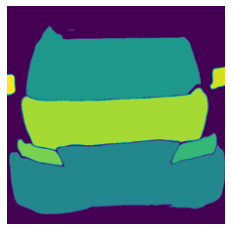

In [30]:
plt.imshow(k)
plt.axis('off')
#plt.savefig('Acura_Seg.pdf',bbox_inches='tight')

(-0.5, 223.5, 223.5, -0.5)

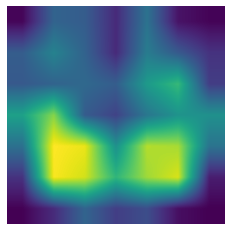

In [31]:
plt.imshow(c)
plt.axis('off')
#plt.savefig('Acura_Seg.pdf',bbox_inches='tight')

In [33]:
masks = visualization_seg_masks.generateUnaryMasks(k, segmentCount=18)

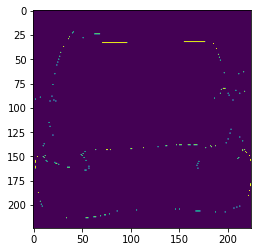

In [42]:
plt.imshow(masks[2])

In [4]:
camMasks = [c * mask for mask in masks]

NameError: name 'masks' is not defined

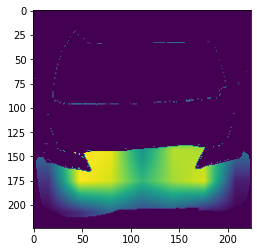

In [48]:
plt.imshow(camMasks[7])

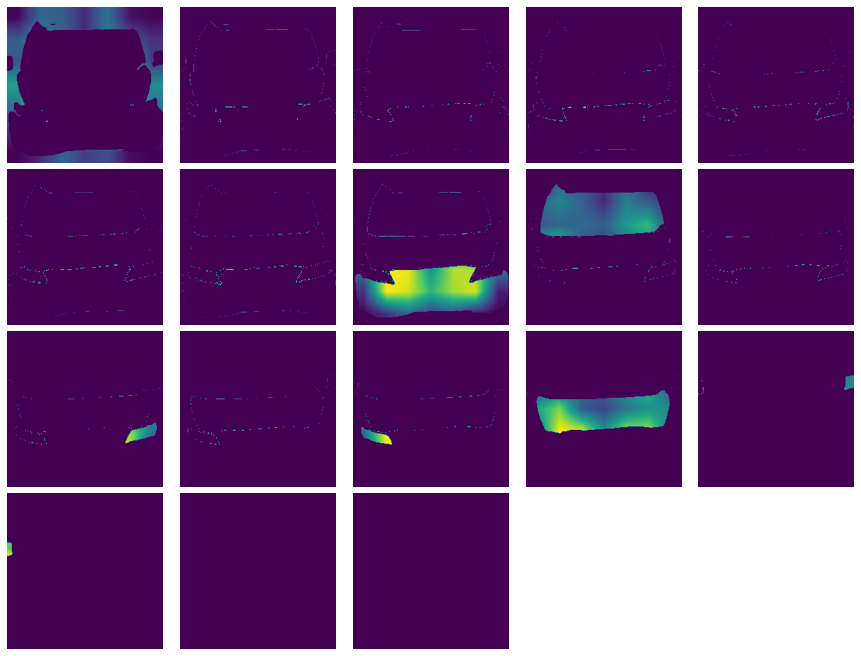

In [61]:
fig = plt.figure(constrained_layout=True)
fig.set_figheight(9)
fig.set_figwidth(12)
grid = fig.add_gridspec(4,5)

i = 0
for row in range(5):
    for col in range(5):
        if i >= 18:
            break
        ax = fig.add_subplot(grid[row,col])
        ax.imshow(camMasks[i])
        i += 1
        ax.axis('off')
plt.savefig('Acura_CamOverlay.pdf')

Using given Segmentation Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz
Using given CAM Data.
Loading data from file at G:/XAI-Vehicle-Classification/preGenData/CompCars_original/SwinBase/valAllCAMsLayer.npz
Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\Single_valAllCAMsLayer_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSegs_23_09_2022.pdf


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:135: UserWarning: No pipeline configured. If pipeline should be applied specify either pipelineCfg or camConfig. desired images must match shape automatically.
  warnings.warn('No pipeline configured. If pipeline should be applied specify either pipelineCfg or camConfig. '


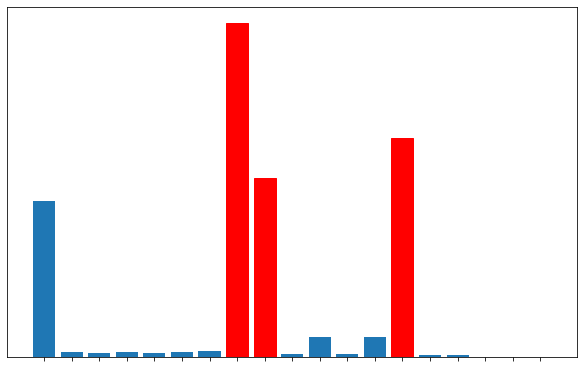

In [14]:
generate_statistics_single.generate_bar_cam_intersection_percOnly(camData='G:/XAI-Vehicle-Classification/preGenData/CompCars_original/SwinBase/valAllCAMsLayer.npz', 
                                                         segData='G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz',
                                                         segConfig=configSeg, segCheckpoint=checkpointSeg,
                                                         imgRoot=imgRootValOriginal, imgName='Acura_Acura_ILX_3c11ef9e42931b.jpg',
                                                         fileExtension='.pdf')